In [1]:
from explainability_module import ExplainabilityModule
from dataset_manager.movie_lens_manager import MovieLensManager

In [2]:
exp = ExplainabilityModule()

In [3]:
exp.plot_attention_maps("val", (), "vanilla")

FileNotFoundError: [Errno 2] No such file or directory: './data/llm/vanilla/xai_artifacts/val_().csv'

In [ ]:
import torch

from llm_manager.graph_prompter_hf.config import GRAPH_PROMPTER_TOKEN_TYPE_VALUES

token_type_ids = torch.tensor([[1, 2, 3, 4]])
input_embeds = torch.rand((1,))
source_mask = (token_type_ids == GRAPH_PROMPTER_TOKEN_TYPE_VALUES[-4]).int()
target_mask = (token_type_ids == GRAPH_PROMPTER_TOKEN_TYPE_VALUES[-2]).int()
source_mask = source_mask.unsqueeze(-1).repeat(1, 1, inputs_embeds.shape[2])
target_mask = target_mask.unsqueeze(-1).repeat(1, 1, inputs_embeds.shape[2])
ones = torch.ones_like(inputs_embeds, device=inputs_embeds.device)
new_inputs_embeds = (inputs_embeds * (1 - source_mask) + ones * source_mask) * (
    1 - target_mask
) + ones * target_mask
inputs_embeds = new_inputs_embeds

tensor([[2., 2., 0., 2., 0.],
        [2., 0., 2., 0., 0.]])

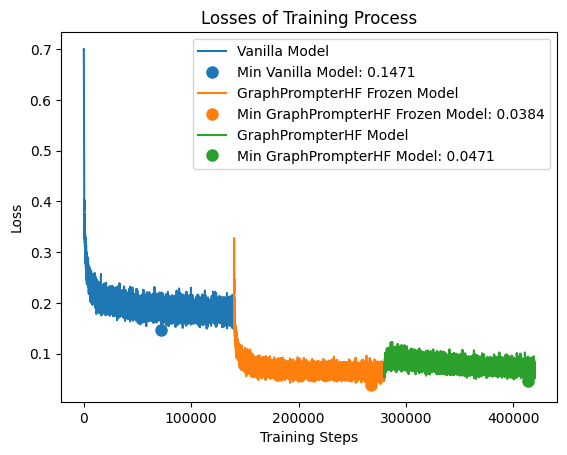

In [4]:
exp.plot_training_losses(True)

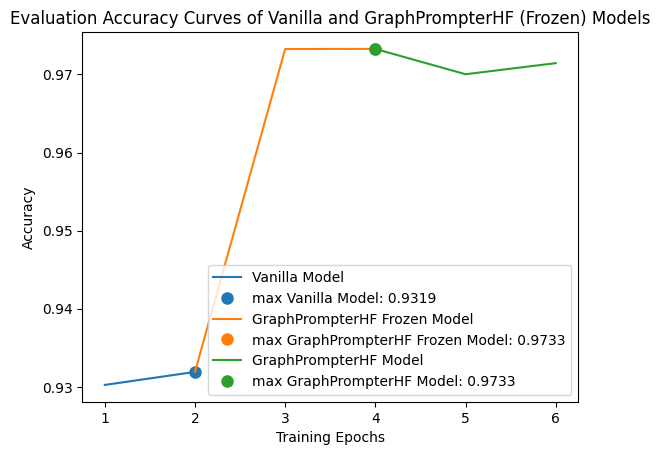

In [5]:
exp.plot_training_accuracies(True)

In [ ]:
import json
from typing import List, Tuple, Optional, Callable
import random as rd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import networkx as nx
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import joblib
from matplotlib.collections import PathCollection
import ast

from dataset_manager.kg_manager import ROOT
from llm_manager.vanilla.config import VANILLA_TOKEN_DICT
from llm_manager.graph_prompter_hf.config import (
    GRAPH_PROMPTER_TOKEN_DICT,
)


In [ ]:
from graph_representation_generator import GraphRepresentationGenerator
from dataset_manager.kg_manager import (
    MovieLensManager,
    PROMPT_KGE_DIMENSION,
    INPUT_EMBEDS_REPLACE_KGE_DIMENSION,
    ROOT,
)
from llm_manager import (
    PromptBertClassifier,
    VanillaBertClassifier,
    GraphPrompterHFClassifier,
    get_token_type_ranges,
    sort_ranges,
)

kg_manager = MovieLensManager()

graph_representation_generator_prompt = GraphRepresentationGenerator(
    kg_manager.data,
    kg_manager.gnn_train_data,
    kg_manager.gnn_val_data,
    kg_manager.gnn_test_data,
    kge_dimension=PROMPT_KGE_DIMENSION,
)
graph_representation_generator_graph_prompter_hf = GraphRepresentationGenerator(
    kg_manager.data,
    kg_manager.gnn_train_data,
    kg_manager.gnn_val_data,
    kg_manager.gnn_test_data,
    hidden_channels=INPUT_EMBEDS_REPLACE_KGE_DIMENSION,
    kge_dimension=INPUT_EMBEDS_REPLACE_KGE_DIMENSION,
)
prompt_embeddings = graph_representation_generator_prompt.get_saved_embeddings("prompt")
graph_prompter_hf_embeddings = (
    graph_representation_generator_graph_prompter_hf.get_saved_embeddings(
        "graph_prompter_hf"
    )
)
save_prompt = False
save_graph_prompter_hf = False
if prompt_embeddings is None:
    prompt_embeddings = graph_representation_generator_prompt.generate_embeddings(
        kg_manager.llm_df
    )
    save_prompt = True
if graph_prompter_hf_embeddings is None:
    graph_prompter_hf_embeddings = (
        graph_representation_generator_graph_prompter_hf.generate_embeddings(
            kg_manager.llm_df
        )
    )
    save_graph_prompter_hf = True

kg_manager.append_prompt_graph_embeddings(prompt_embeddings, save=save_prompt)
kg_manager.append_graph_prompter_hf_graph_embeddings(
    graph_prompter_hf_embeddings, save=save_graph_prompter_hf
)
VANILLA_ROOT = f"{ROOT}/llm/vanilla"
PROMPT_ROOT = f"{ROOT}/llm/prompt"
INPUT_EMBEDS_REPLACE_ROOT = f"{ROOT}/llm/graph_prompter_hf"
vanilla_bert_classifier = VanillaBertClassifier(
    kg_manager.llm_df,
    kg_manager.source_df,
    kg_manager.target_df,
    root_path=VANILLA_ROOT,
    false_ratio=-1,
)
prompt_bert_classifier = PromptBertClassifier(
    kg_manager,
    graph_representation_generator_prompt.get_embedding,
    root_path=PROMPT_ROOT,
    model_max_length=512,
    false_ratio=-1,
)
graph_prompter_hf_bert_classifier = GraphPrompterHFClassifier(
    kg_manager,
    graph_representation_generator_graph_prompter_hf.get_embedding,
    root_path=INPUT_EMBEDS_REPLACE_ROOT,
    false_ratio=-1,
)
dataset_vanilla = kg_manager.generate_vanilla_dataset(
    vanilla_bert_classifier.tokenize_function
)
dataset_prompt = kg_manager.generate_prompt_embedding_dataset(
    prompt_bert_classifier.tokenize_function,
)
dataset_graph_prompter_hf = kg_manager.generate_graph_prompter_hf_embedding_dataset(
    graph_prompter_hf_bert_classifier.tokenizer.sep_token,
    graph_prompter_hf_bert_classifier.tokenizer.pad_token,
    graph_prompter_hf_bert_classifier.tokenize_function,
)


loading pretrained model
Device: 'cuda'
loading pretrained model
Device: 'cuda'


In [ ]:
subset_vanilla = subset = DatasetDict(
    {
        "train": dataset_vanilla["train"].select(range(5)),
        "test": dataset_vanilla["test"].select(range(5)),
        "val": dataset_vanilla["val"].select(range(5)),
    }
)
subset_prompt = subset = DatasetDict(
    {
        "train": dataset_prompt["train"].select(range(5)),
        "test": dataset_prompt["test"].select(range(5)),
        "val": dataset_prompt["val"].select(range(5)),
    }
)
subset_graph_prompter_hf = subset = DatasetDict(
    {
        "train": dataset_graph_prompter_hf["train"].select(range(5)),
        "test": dataset_graph_prompter_hf["test"].select(range(5)),
        "val": dataset_graph_prompter_hf["val"].select(range(5)),
    }
)

In [ ]:
(
    len(subset_vanilla["train"]["token_type_ranges"][0]),
    len(subset_prompt["train"]["token_type_ranges"][0]),
    len(subset_graph_prompter_hf["train"]["token_type_ranges"][0]),
)

(9, 13, 13)

In [ ]:
graph_prompter_hf_bert_classifier.forward_dataset_and_save_outputs(
    subset_graph_prompter_hf,
    kg_manager.get_vanilla_tokens_as_df,
    epochs=1,
    batch_size=512,
    include_graph_embeddings=True,
    force_recompute=True,
)

train Forward Epoch 1 from 1
test Forward Epoch 1 from 1
val Forward Epoch 1 from 1


,source_id,target_id,title,genres,labels,predictions,split,hidden_states,attentions,logits
0,0,5,heat ( 1995 ),"['action ', 'crime ', 'thriller']",1,1,train,[[[[ 0.9417381 0.11100921 -8.244461 0.076...,"[[[[0.16464299 0.05868959], [0.1322025 0.0422...","[[-1.7766137, 1.8898944], [-1.8177586, 1.93541..."
1,0,89,bottle rocket ( 1996 ),"['adventure ', 'comedy ', 'crime ', 'romance']",1,1,train,[[[[ 0.9417381 0.11100921 -8.244461 0.076...,"[[[[0.08707035 0.08129981], [0.0573387 0.0408...","[[-1.4336724, 1.2893708], [-1.3440378, 1.19211..."
2,0,97,braveheart ( 1995 ),"['action ', 'drama ', 'war']",1,1,train,[[[[ 0.9417381 0.11100921 -8.244461 0.076...,"[[[[0.18892497 0.07347225], [0.15924668 0.0320...","[[-2.1496012, 2.2889469], [-2.1591437, 2.29587..."
3,0,184,billy madison ( 1995 ),['comedy'],1,1,train,[[[[ 0.9417381 0.11100921 -8.244461 0.076...,"[[[[0.13144213 0.07449591], [0.10240837 0.0418...","[[-1.8673522, 1.9551715], [-1.8508039, 1.93613..."
4,0,224,star wars : episode iv - a new hope ( 1977 ),"['action ', 'adventure ', 'sci - fi']",1,1,train,[[[[ 0.9417381 0.11100921 -8.244461 0.076...,"[[[[0.1672216 0.03307326], [0.13944641 0.0127...","[[-2.308021, 2.4065332], [-2.3252587, 2.413116..."
5,0,2,grumpier old men ( 1995 ),"['comedy ', 'romance']",1,1,test,[[[[ 0.9417381 0.11100921 -8.244461 0.076...,"[[[[0.10049947 0.04385313], [0.07307684 0.0257...","[[-1.6259272, 1.5594212], [-1.6913435, 1.61802..."
6,0,62,from dusk till dawn ( 1996 ),"['action ', 'comedy ', 'horror ', 'thriller']",1,1,test,[[[[ 0.9417381 0.11100921 -8.244461 0.076...,"[[[[0.12094098 0.03412018], [0.09328769 0.0330...","[[-1.7587483, 1.6810125], [-1.7248819, 1.65209..."
7,0,130,canadian bacon ( 1995 ),"['comedy ', 'war']",1,1,test,[[[[ 0.9417381 0.11100921 -8.244461 0.076...,"[[[[0.12234044 0.05223521], [0.0893386 0.12851...","[[-0.65239763, 0.51814604], [-0.6463058, 0.505..."
8,0,190,clerks ( 1994 ),['comedy'],1,1,test,[[[[ 0.9417381 0.11100921 -8.244461 0.076...,"[[[[0.12471834 0.08507454], [0.09652129 0.0307...","[[-1.8945556, 2.0015123], [-1.8521284, 1.94826..."
9,0,257,pulp fiction ( 1994 ),"['comedy ', 'crime ', 'drama ', 'thriller']",1,1,test,[[[[ 0.9417381 0.11100921 -8.244461 0.076...,"[[[[0.1919739 0.05104928], [0.16109394 0.0255...","[[-2.2058952, 2.2857976], [-2.2250519, 2.29491..."


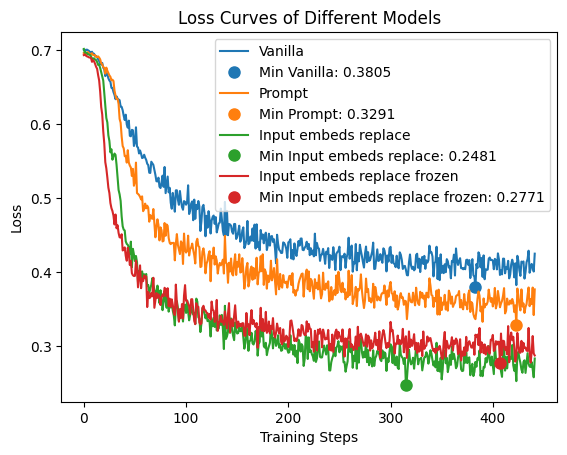

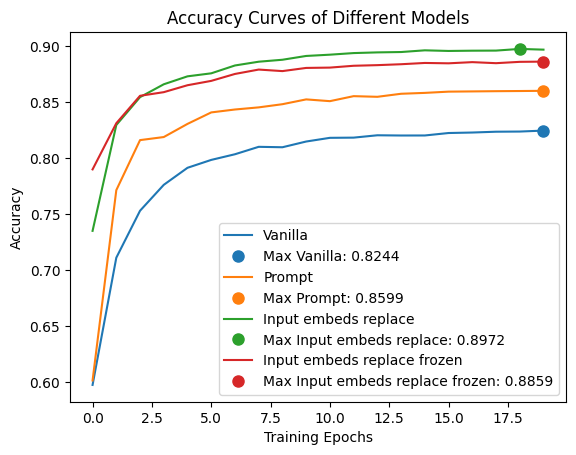

In [ ]:
exp.plot_training_losses(
    root_path=f"{ROOT}/llm", save_path="./images/training_losses.png"
)
exp.plot_training_accuracies(
    root_path=f"{ROOT}/llm", save_path="./images/training_accuracies.png"
)

In [ ]:
root_path = f"{ROOT}/llm"
dataset_path = "/dataset"
checkpoint = "/training/checkpoint-4420/trainer_state.json"
dataset_vanilla = load_from_disk(f"{root_path}/vanilla{dataset_path}")
dataset_prompt = load_from_disk(f"{root_path}/prompt{dataset_path}")
dataset_graph_prompter_hf = load_from_disk(
    f"{root_path}/graph_prompter_hf{dataset_path}"
)

c:\Users\MARS\.conda\envs\hauptprojekt\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/67 [00:00<?, ?it/s]

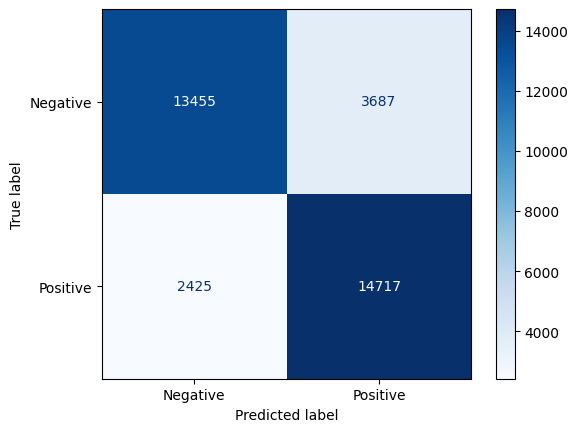

  0%|          | 0/67 [00:00<?, ?it/s]

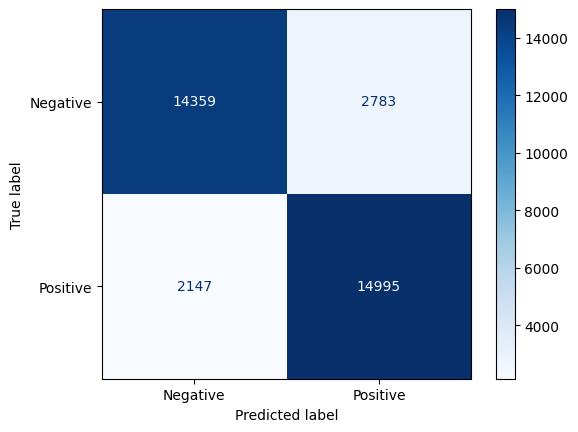

  0%|          | 0/67 [00:00<?, ?it/s]

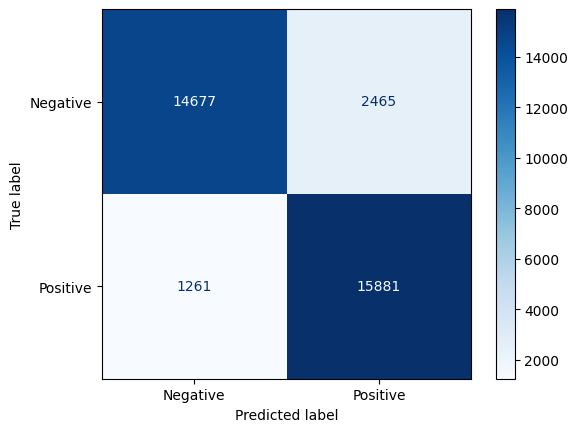

In [ ]:
ClassifierBase.plot_confusion_matrix(
    split="val", dataset=dataset_vanilla, batch_size=512
)
ClassifierBase.plot_confusion_matrix(
    split="val", dataset=dataset_prompt, batch_size=512
)
ClassifierBase.plot_confusion_matrix(
    split="val", dataset=dataset_graph_prompter_hf, batch_size=512
)
ClassifierBase.plot_confusion_matrix(
    split="val", dataset=dataset_graph_prompter_hf, batch_size=512
)